In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc
import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GroupKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Conv2D,Convolution2D, Dense, Dropout, Flatten, MaxPooling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from keras import backend as K
from tensorflow.keras.metrics import TopKCategoricalAccuracy

import pandas as pd
from scipy.stats import rankdata

In [2]:
IMG_WIDTH = 40
IMG_HEIGHT = 40
BATCH_SIZE = 16

X = np.load('/kaggle/input/arc-agi-images-for-deeplearning/augmented_image_dataset_imageData.npy')
X = X[:, :, :, :, 0]
X = X/9
X = np.expand_dims(X, -1)

X1 = X[:, 0]
X2 = X[:, 1]
print(X1.shape, X2.shape)


X_meta = pd.read_csv('/kaggle/input/arc-agi-images-for-deeplearning/augmented_image_dataset_metadata.csv')
labels = pd.read_csv('/kaggle/input/arc-agi-images-for-deeplearning/function_dataset.csv')
X_meta = X_meta.merge(labels, on='task_id', how='left')
print('X_meta shape:', X_meta.shape)
X_meta.head(3)


Y = X_meta[[c for c in X_meta.columns if c not in ['task_id', 'image_id']]].values
print('Y shape:', Y.shape)

(78120, 40, 40, 1) (78120, 40, 40, 1)
X_meta shape: (78120, 162)
Y shape: (78120, 160)


In [3]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
## GOOD MODEL

# def create_kha_model():
#     inputA = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1))
#     inputB = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1))

#     x = Conv2D(32, (3, 3), padding='valid')(inputA)
#     x = Activation('relu')(x)
#     # x = MaxPooling2D(pool_size=(2, 2))(x)
#     # x = BatchNormalization()(x)

#     x = Conv2D(16, (3, 3), padding='valid')(x)
#     # x = Activation('relu')(x)
#     # x = MaxPooling2D(pool_size=(2, 2))(x)
#     # x = BatchNormalization()(x)

#     y = Conv2D(32, (3, 3), padding='valid')(inputB)
#     y = Activation('relu')(y)
#     # y = MaxPooling2D(pool_size=(2, 2))(y)
#     # y = BatchNormalization()(y)

#     y = Conv2D(16, (3, 3), padding='valid')(y)
#     # y = Activation('relu')(y)
#     # y = MaxPooling2D(pool_size=(2, 2))(y)
#     # y = BatchNormalization()(y)

#     out = Concatenate()([x, y])
#     out = Flatten()(out)
#     out = Dense(512)(out)
#     out = Dropout(0.2)(out)
#     out = Activation('relu')(out)
#     out = Dense(160)(out)
#     out = Activation('sigmoid')(out)
    
#     model = Model(inputs=[inputA, inputB], outputs=out)
#     return model

In [5]:
def create_kha_model():
    inputA = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1))
    inputB = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1))

    x = Conv2D(32, (3, 3), padding='valid')(inputA)
    x = Activation('relu')(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = BatchNormalization()(x)

    x = Conv2D(16, (3, 3), padding='valid')(x)
    # x = Activation('relu')(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = BatchNormalization()(x)

    y = Conv2D(32, (3, 3), padding='valid')(inputB)
    y = Activation('relu')(y)
    # y = MaxPooling2D(pool_size=(2, 2))(y)
    # y = BatchNormalization()(y)

    y = Conv2D(16, (3, 3), padding='valid')(y)
    # y = Activation('relu')(y)
    # y = MaxPooling2D(pool_size=(2, 2))(y)
    # y = BatchNormalization()(y)

    out = Concatenate()([x, y])
    out = Flatten()(out)
    out = Dense(512)(out)
    out = Dropout(0.2)(out)
    out = Activation('relu')(out)
    out = Dense(160)(out)
    out = Activation('sigmoid')(out)
    
    model = Model(inputs=[inputA, inputB], outputs=out)
    return model

## Training Specs

- BinaryCrossEntropy is used as the training loss for this multi-label classification problem, due to the labels affording many indices having values 1. It works better than CategoricalCrossEntropy.
- Top-k-Categorical-Accuracy and F1 are used as metrics. We are more interested in the ranking of the probability outputs for 160 operations (for a given input-output pair), since it relates to the sampling method in the ARC solver later on. So top-k-cat-acc is used to let us grasp the initial judgment on whether if the validation results are better than the random sampling odds.
- Batch size, learning rate, network architectures... are all moderately selected through some brute-force efforts. Rooms for improvements are still there.

In [6]:
BATCH_SIZE = 32
EPOCHS = 200
LR = 0.001

fold_training_history = []
oof_preds = np.zeros((len(X1), 160))
kf = GroupKFold(n_splits=5)

for i_fold, (tr_idx, va_idx) in enumerate(kf.split(X, Y, groups=X_meta.task_id.values)):

    print(f'\n\n------ Training fold {i_fold} ------')
    X1_tr, X2_tr, Y_tr = X1[tr_idx], X2[tr_idx], Y[tr_idx]
    X1_va, X2_va, Y_va = X1[va_idx], X2[va_idx], Y[va_idx]

    md = create_kha_model()
    
    reduce_lr = ReduceLROnPlateau(monitor='val_top50', factor=0.1, patience=2)
    optimizer = Adam(learning_rate=LR)

    es = EarlyStopping(monitor='val_top30', min_delta=0,patience=6, verbose=0)
    
    md.compile(optimizer=optimizer, 
               # loss=CategoricalCrossentropy(), 
               loss=BinaryCrossentropy(), 
               # metrics=[f1],
              metrics=[
                      TopKCategoricalAccuracy(k=10, name='top10'),
                      TopKCategoricalAccuracy(k=30, name='top30'),
                      TopKCategoricalAccuracy(k=50, name='top50'),
                      TopKCategoricalAccuracy(k=70, name='top70'),
                      f1
                      ],
              )
    # print(md.summary())


    history = md.fit([X1_tr, X2_tr], 
                      Y_tr, 
                     batch_size=BATCH_SIZE,
                     epochs=EPOCHS, 
                     steps_per_epoch= (len(X1) // BATCH_SIZE) // 200, 
                     # steps_per_epoch= (len(X1) // BATCH_SIZE) , 
                     validation_data=([X1_va, X2_va],  Y_va),
                     verbose=1,
                     callbacks=[reduce_lr, es])


    val_prediction = md.predict([X1_va, X2_va])
    oof_preds[va_idx] = val_prediction

    K.clear_session()
    del X1_tr, X2_tr, X1_va, X2_va
    gc.collect()

    fold_training_history.append(history.history)



------ Training fold 0 ------
Epoch 1/200
12/12 [==============================] - 10s 202ms/step - loss: 0.3657 - top10: 0.1198 - top30: 0.3438 - top50: 0.5104 - top70: 0.6901 - f1: 0.2035 - val_loss: 0.2706 - val_top10: 0.0465 - val_top30: 0.3576 - val_top50: 0.5286 - val_top70: 0.5887 - val_f1: 0.1287
Epoch 2/200
12/12 [==============================] - 1s 128ms/step - loss: 0.2666 - top10: 0.1120 - top30: 0.3984 - top50: 0.5625 - top70: 0.7161 - f1: 0.1879 - val_loss: 0.2562 - val_top10: 0.1218 - val_top30: 0.2533 - val_top50: 0.4625 - val_top70: 0.5681 - val_f1: 0.1536
Epoch 3/200
12/12 [==============================] - 1s 129ms/step - loss: 0.2463 - top10: 0.0964 - top30: 0.3516 - top50: 0.5599 - top70: 0.7083 - f1: 0.2163 - val_loss: 0.2484 - val_top10: 0.1151 - val_top30: 0.2892 - val_top50: 0.4273 - val_top70: 0.6673 - val_f1: 0.1681
Epoch 4/200
12/12 [==============================] - 1s 132ms/step - loss: 0.2447 - top10: 0.1380 - top30: 0.4141 - top50: 0.6354 - top70: 0.7

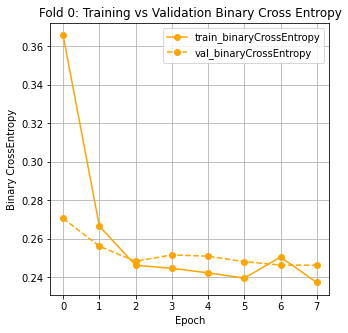

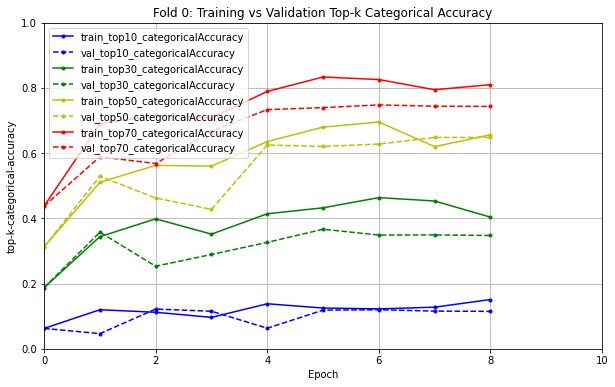

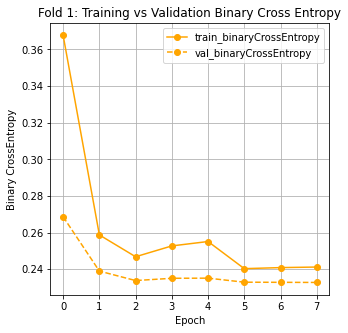

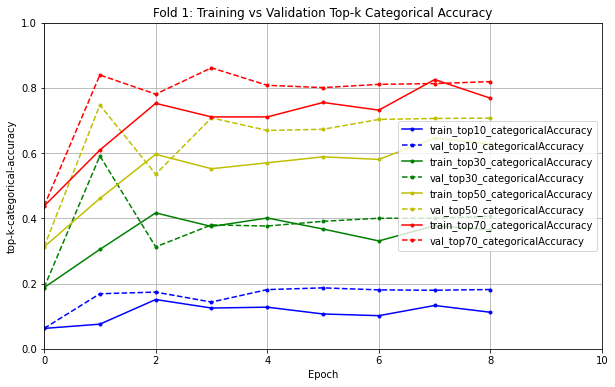

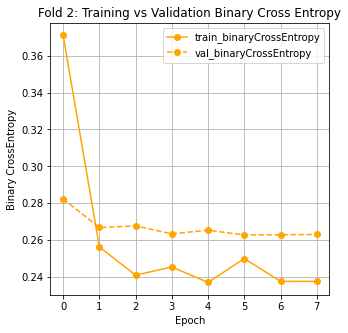

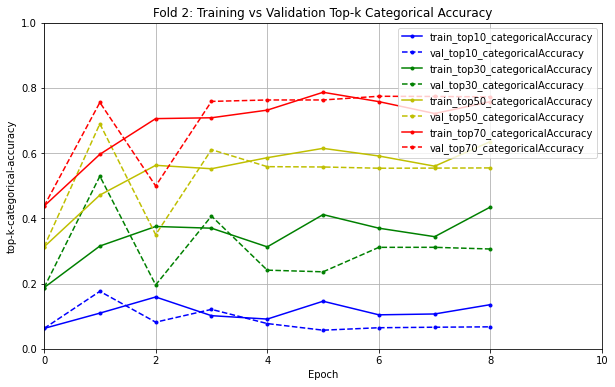

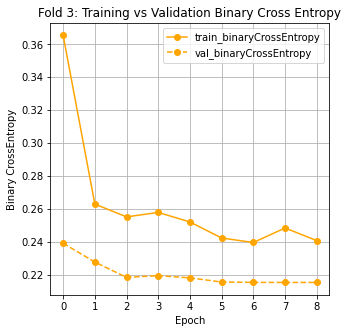

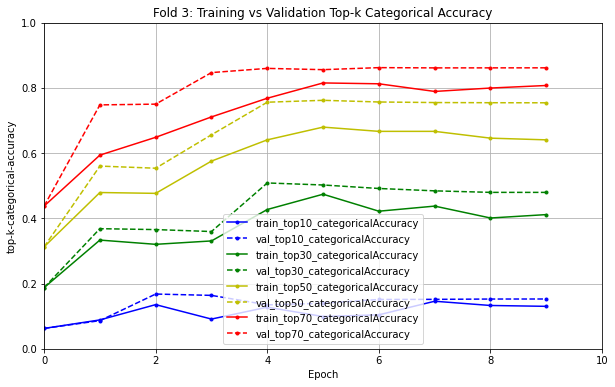

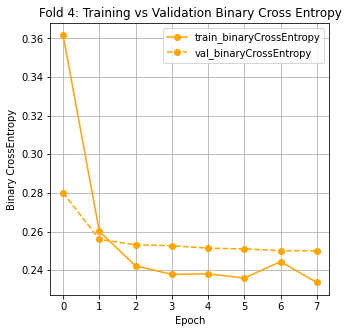

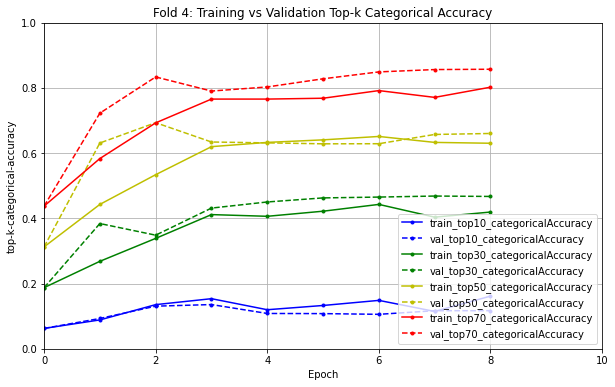

In [7]:
for i, data in enumerate(fold_training_history):
    plt.figure(figsize=(5,5));
    plt.plot(data['loss'], '-o', color='orange', label='train_binaryCrossEntropy');
    plt.plot(data['val_loss'], '--o' , color='orange', label='val_binaryCrossEntropy');
    plt.title(f'Fold {i}: Training vs Validation Binary Cross Entropy');
    plt.legend(loc="best");
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Binary CrossEntropy', fontsize=10)
    plt.grid();
    
    plt.figure(figsize=(10,6));
    plt.plot([10/160] + data['top10'], 'b.-', label='train_top10_categoricalAccuracy');
    plt.plot([10/160] + data['val_top10'], 'b.--', label='val_top10_categoricalAccuracy');
    plt.plot([30/160] + data['top30'], 'g.-', label='train_top30_categoricalAccuracy');
    plt.plot([30/160] + data['val_top30'], 'g.--', label='val_top30_categoricalAccuracy');
    plt.plot([50/160] + data['top50'], 'y.-', label='train_top50_categoricalAccuracy');
    plt.plot([50/160] + data['val_top50'], 'y.--', label='val_top50_categoricalAccuracy');
    plt.plot([70/160] + data['top70'], 'r.-', label='train_top70_categoricalAccuracy');
    plt.plot([70/160] + data['val_top70'], 'r.--', label='val_top70_categoricalAccuracy');

    ax = plt.gca()
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 1])
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('top-k-categorical-accuracy', fontsize=10)
    plt.legend(loc="best");
    plt.grid();
    plt.title(f'Fold {i}: Training vs Validation Top-k Categorical Accuracy');

### Some remarks

- All top-k-categorical-accuracy metrics improve significantly from the starting random sampling odds (epoch=0)
- Some folds have validation accuracy higher than training accuracy for unknown reason (maybe due to the validation tasks are easier than training tasks in that specific fold)
- May need to come up with better metrics. However this analysis is merely a means to preliminarily judge how this model performs (as if it can converge or even work with this dataset). Final experimental results are more important which will be implemented in the ARC testing using the out-of-fold predictions.

## Preliminary Analysis

- We will measure how many tasks that will have a better probability distribution (a distribution that can improve a totally random sampling process)
- We do this by analyzing the aggregated prediction result (for each task), then averaging the ranking of the ground-truth operations and compare it with the random odds. We only care about whether the positive labels within a given task are ranked higher than the averaged random rank (80)
- We also want to analyze which operations are the best to be detected by the CNN.

In [8]:
ops = [c for c in X_meta.columns if c not in ['task_id','image_id']]
oof_ranked = rankdata(oof_preds, method='ordinal', axis=1)
oof_df = pd.DataFrame(oof_ranked, columns=ops)
oof_df['task_id'] = X_meta['task_id']
oof_df = oof_df.groupby('task_id').mean()
oof_df

,identity,add,subtract,multiply,divide,invert,even,double,halve,flip,...,gravitate,inbox,outbox,box,shoot,occurrences,frontiers,compress,hperiod,vperiod
task_id,,,,,,,,,,,,,,,,,,,,,
007bbfb7,134.126667,115.623333,125.390000,111.546667,12.813333,49.153333,92.936667,58.020000,62.460000,70.353333,...,49.310000,29.636667,55.690000,97.463333,117.990000,20.630000,19.520000,58.900000,7.776667,2.030000
00d62c1b,132.213333,101.826667,124.863333,116.316667,31.220000,46.263333,28.346667,52.430000,49.690000,76.946667,...,27.650000,73.120000,77.983333,134.483333,100.956667,44.200000,7.840000,26.056667,6.803333,11.326667
017c7c7b,135.277778,115.088889,124.427778,108.122222,15.794444,50.227778,92.194444,59.077778,63.127778,69.522222,...,48.344444,30.005556,56.044444,96.805556,118.283333,17.588889,21.733333,59.533333,7.594444,2.000000
025d127b,132.725000,101.750000,124.283333,114.650000,31.783333,43.633333,28.266667,49.600000,49.925000,73.800000,...,24.583333,72.925000,80.583333,134.950000,100.833333,40.966667,6.741667,27.200000,3.141667,10.683333
045e512c,131.416667,120.355556,135.694444,131.600000,31.644444,80.766667,58.644444,87.622222,45.122222,94.255556,...,60.466667,52.133333,69.922222,122.033333,107.000000,43.300000,4.538889,34.444444,49.138889,40.183333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fcb5c309,127.083333,122.100000,121.722222,108.027778,30.355556,56.772222,48.311111,70.583333,35.194444,104.822222,...,30.522222,28.666667,78.300000,116.011111,100.733333,59.522222,17.888889,13.005556,31.900000,13.594444
fcc82909,132.488889,102.183333,125.533333,115.311111,31.172222,44.427778,28.938889,49.716667,49.366667,73.316667,...,25.311111,74.794444,79.633333,135.238889,103.355556,41.211111,6.522222,26.738889,3.216667,10.494444
feca6190,130.930000,121.876667,125.366667,112.573333,30.383333,59.183333,54.456667,75.876667,35.623333,100.803333,...,30.786667,31.650000,77.010000,118.290000,106.386667,59.600000,11.110000,15.700000,32.056667,11.743333


In [9]:
results = {}
for task_id, row in oof_df.iterrows():
    y = labels[labels.task_id==task_id][ops]
    r = (row.values - 80)* y.values
    results[task_id] = r.mean()

results

{'007bbfb7': -0.4274375,
 '00d62c1b': 2.605583333333333,
 '017c7c7b': 1.462361111111111,
 '025d127b': 4.5825,
 '045e512c': 6.556006944444445,
 '0520fde7': -0.07545138888888889,
 '05269061': 3.8068750000000002,
 '05f2a901': 1.8749652777777777,
 '06df4c85': 6.989965277777777,
 '08ed6ac7': 2.3422916666666667,
 '09629e4f': 2.964296875,
 '0962bcdd': 3.81140625,
 '0a938d79': 6.180546875,
 '0b148d64': 1.087638888888889,
 '0ca9ddb6': 2.0089236111111113,
 '0d3d703e': -0.4312239583333334,
 '0dfd9992': 6.990104166666666,
 '0e206a2e': 8.49875,
 '10fcaaa3': 2.88953125,
 '11852cab': 1.5152430555555552,
 '1190e5a7': 2.4322916666666665,
 '137eaa0f': 5.633472222222222,
 '150deff5': 3.6103125000000005,
 '178fcbfb': 5.329722222222221,
 '1a07d186': 7.573888888888888,
 '1b2d62fb': 1.8354166666666665,
 '1b60fb0c': 4.975659722222223,
 '1bfc4729': 1.9507291666666666,
 '1c786137': 1.1465625,
 '1caeab9d': 4.9646875,
 '1cf80156': 1.3084375,
 '1e0a9b12': 1.4668402777777778,
 '1e32b0e9': 6.137152777777777,
 '1f0c7

Almost all tasks have positive gains, meaning we can improve the searching process by using the probability outputs of the CNN.

Now we'll find out which operations are helping the most

In [10]:
labels = labels.sort_values('task_id')
ops_score = np.mean(labels[ops].values * oof_df.values, axis=0)

In [11]:
ranked_idx = np.argsort(ops_score)[::-1]

for j, idx in enumerate(ranked_idx):
    print(f'Rank {j}: {ops[j]}')

Rank 0: identity
Rank 1: add
Rank 2: subtract
Rank 3: multiply
Rank 4: divide
Rank 5: invert
Rank 6: even
Rank 7: double
Rank 8: halve
Rank 9: flip
Rank 10: equality
Rank 11: contained
Rank 12: combine
Rank 13: intersection
Rank 14: difference
Rank 15: dedupe
Rank 16: order
Rank 17: repeat
Rank 18: greater
Rank 19: size
Rank 20: merge
Rank 21: maximum
Rank 22: minimum
Rank 23: valmax
Rank 24: valmin
Rank 25: argmax
Rank 26: argmin
Rank 27: mostcommon
Rank 28: leastcommon
Rank 29: initset
Rank 30: both
Rank 31: either
Rank 32: increment
Rank 33: decrement
Rank 34: crement
Rank 35: sign
Rank 36: positive
Rank 37: toivec
Rank 38: tojvec
Rank 39: sfilter
Rank 40: mfilter
Rank 41: extract
Rank 42: totuple
Rank 43: first
Rank 44: last
Rank 45: insert
Rank 46: remove
Rank 47: other
Rank 48: interval
Rank 49: astuple
Rank 50: product
Rank 51: pair
Rank 52: branch
Rank 53: compose
Rank 54: chain
Rank 55: matcher
Rank 56: rbind
Rank 57: lbind
Rank 58: power
Rank 59: fork
Rank 60: apply
Rank 61: 

Most of the ops in the top are simple ops (add, subtract, ...) or ops that can be detected by Conv2D (invert, flip, contained, intersection...)

### Next
- We will use the out-of-fold probability distributions to accelerate the searching process in program synthesis
- Integrating this deep learning process with the program synthesis framework in an end-to-end learnable fashion (maybe with GPU as well) is a research direction worth of values.

In [12]:
## Save out-of-fold predictions for ARC solver in the next step
np.save('oof_preds.npy', oof_preds)
print(fold_training_history)

[{'loss': [0.36571288108825684, 0.26664358377456665, 0.2462901473045349, 0.2447226196527481, 0.24237744510173798, 0.23965603113174438, 0.25057604908943176, 0.23739708960056305], 'top10': [0.1197916641831398, 0.1119791641831398, 0.0963541641831398, 0.1380208283662796, 0.125, 0.1223958358168602, 0.1276041716337204, 0.1510416716337204], 'top30': [0.34375, 0.3984375, 0.3515625, 0.4140625, 0.4322916567325592, 0.4635416567325592, 0.453125, 0.4036458432674408], 'top50': [0.5104166865348816, 0.5625, 0.5598958134651184, 0.6354166865348816, 0.6796875, 0.6953125, 0.6197916865348816, 0.65625], 'top70': [0.6901041865348816, 0.7161458134651184, 0.7083333134651184, 0.7890625, 0.8333333134651184, 0.8255208134651184, 0.7942708134651184, 0.8098958134651184], 'f1': [0.20354557037353516, 0.18786002695560455, 0.21629422903060913, 0.18849705159664154, 0.22405952215194702, 0.22284401953220367, 0.20384001731872559, 0.20996494591236115], 'val_loss': [0.27063384652137756, 0.25621625781059265, 0.2483924925327301

In [13]:
# ## Best training stats

# ------ Training fold 0 ------
# Epoch 1/200
# 12/12 [==============================] - 3s 191ms/step - loss: 0.3521 - top10: 0.1042 - top30: 0.3203 - top50: 0.4766 - top70: 0.6120 - f1: 0.2033 - val_loss: 0.2619 - val_top10: 0.0678 - val_top30: 0.2878 - val_top50: 0.4337 - val_top70: 0.6665 - val_f1: 0.1682
# Epoch 2/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2591 - top10: 0.0938 - top30: 0.3568 - top50: 0.5156 - top70: 0.6901 - f1: 0.1970 - val_loss: 0.2565 - val_top10: 0.1217 - val_top30: 0.4087 - val_top50: 0.5006 - val_top70: 0.6146 - val_f1: 0.1929
# Epoch 3/200
# 12/12 [==============================] - 1s 124ms/step - loss: 0.2526 - top10: 0.1536 - top30: 0.4453 - top50: 0.6354 - top70: 0.7630 - f1: 0.2238 - val_loss: 0.2509 - val_top10: 0.0989 - val_top30: 0.3419 - val_top50: 0.5633 - val_top70: 0.7736 - val_f1: 0.1736
# Epoch 4/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2453 - top10: 0.1172 - top30: 0.4167 - top50: 0.6432 - top70: 0.8177 - f1: 0.1972 - val_loss: 0.2475 - val_top10: 0.0930 - val_top30: 0.3213 - val_top50: 0.5714 - val_top70: 0.7658 - val_f1: 0.1737
# Epoch 5/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2432 - top10: 0.1042 - top30: 0.4010 - top50: 0.6406 - top70: 0.7812 - f1: 0.1874 - val_loss: 0.2463 - val_top10: 0.1220 - val_top30: 0.2872 - val_top50: 0.5801 - val_top70: 0.7611 - val_f1: 0.1351
# Epoch 6/200
# 12/12 [==============================] - 1s 126ms/step - loss: 0.2376 - top10: 0.1276 - top30: 0.4505 - top50: 0.6589 - top70: 0.7943 - f1: 0.1851 - val_loss: 0.2463 - val_top10: 0.1271 - val_top30: 0.2824 - val_top50: 0.5936 - val_top70: 0.7635 - val_f1: 0.1235
# Epoch 7/200
# 12/12 [==============================] - 1s 126ms/step - loss: 0.2436 - top10: 0.1589 - top30: 0.4609 - top50: 0.6354 - top70: 0.7995 - f1: 0.1962 - val_loss: 0.2455 - val_top10: 0.1235 - val_top30: 0.2863 - val_top50: 0.6429 - val_top70: 0.7642 - val_f1: 0.1361
# Epoch 8/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2524 - top10: 0.1302 - top30: 0.4193 - top50: 0.6094 - top70: 0.7786 - f1: 0.1953 - val_loss: 0.2453 - val_top10: 0.1114 - val_top30: 0.2941 - val_top50: 0.6749 - val_top70: 0.7663 - val_f1: 0.1821
# Epoch 9/200
# 12/12 [==============================] - 1s 135ms/step - loss: 0.2419 - top10: 0.1016 - top30: 0.4193 - top50: 0.6589 - top70: 0.8229 - f1: 0.2061 - val_loss: 0.2453 - val_top10: 0.1123 - val_top30: 0.2954 - val_top50: 0.6750 - val_top70: 0.7661 - val_f1: 0.1831
# Epoch 10/200
# 12/12 [==============================] - 1s 127ms/step - loss: 0.2403 - top10: 0.1302 - top30: 0.4323 - top50: 0.6484 - top70: 0.8073 - f1: 0.2001 - val_loss: 0.2453 - val_top10: 0.1131 - val_top30: 0.2950 - val_top50: 0.6738 - val_top70: 0.7658 - val_f1: 0.1828
# Epoch 11/200
# 12/12 [==============================] - 1s 126ms/step - loss: 0.2381 - top10: 0.1042 - top30: 0.3880 - top50: 0.6068 - top70: 0.8021 - f1: 0.2012 - val_loss: 0.2453 - val_top10: 0.1130 - val_top30: 0.2950 - val_top50: 0.6736 - val_top70: 0.7658 - val_f1: 0.1828
# Epoch 12/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2333 - top10: 0.1276 - top30: 0.4609 - top50: 0.6745 - top70: 0.7734 - f1: 0.2099 - val_loss: 0.2453 - val_top10: 0.1133 - val_top30: 0.2949 - val_top50: 0.6732 - val_top70: 0.7658 - val_f1: 0.1827


# ------ Training fold 1 ------
# Epoch 1/200
# 12/12 [==============================] - 3s 190ms/step - loss: 0.3570 - top10: 0.0938 - top30: 0.3073 - top50: 0.4583 - top70: 0.5703 - f1: 0.1905 - val_loss: 0.2526 - val_top10: 0.1391 - val_top30: 0.4968 - val_top50: 0.7234 - val_top70: 0.8136 - val_f1: 0.2302
# Epoch 2/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2557 - top10: 0.1224 - top30: 0.3698 - top50: 0.5417 - top70: 0.6901 - f1: 0.2123 - val_loss: 0.2402 - val_top10: 0.1985 - val_top30: 0.4876 - val_top50: 0.7069 - val_top70: 0.8052 - val_f1: 0.2302
# Epoch 3/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2616 - top10: 0.1745 - top30: 0.3750 - top50: 0.6146 - top70: 0.7578 - f1: 0.2121 - val_loss: 0.2377 - val_top10: 0.2103 - val_top30: 0.3360 - val_top50: 0.6927 - val_top70: 0.8492 - val_f1: 0.1882
# Epoch 4/200
# 12/12 [==============================] - 1s 129ms/step - loss: 0.2408 - top10: 0.1198 - top30: 0.3646 - top50: 0.5859 - top70: 0.7396 - f1: 0.1796 - val_loss: 0.2442 - val_top10: 0.1828 - val_top30: 0.3845 - val_top50: 0.7320 - val_top70: 0.8486 - val_f1: 0.1213
# Epoch 5/200
# 12/12 [==============================] - 1s 127ms/step - loss: 0.2579 - top10: 0.1068 - top30: 0.3698 - top50: 0.6406 - top70: 0.7760 - f1: 0.1915 - val_loss: 0.2351 - val_top10: 0.1453 - val_top30: 0.5015 - val_top50: 0.7462 - val_top70: 0.8865 - val_f1: 0.2193
# Epoch 6/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2447 - top10: 0.0859 - top30: 0.4349 - top50: 0.6615 - top70: 0.7969 - f1: 0.2069 - val_loss: 0.2343 - val_top10: 0.1547 - val_top30: 0.5222 - val_top50: 0.7365 - val_top70: 0.8865 - val_f1: 0.2032
# Epoch 7/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2386 - top10: 0.1120 - top30: 0.3802 - top50: 0.6641 - top70: 0.8203 - f1: 0.2180 - val_loss: 0.2341 - val_top10: 0.1476 - val_top30: 0.4877 - val_top50: 0.7278 - val_top70: 0.8855 - val_f1: 0.1960
# Epoch 8/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2406 - top10: 0.1016 - top30: 0.3984 - top50: 0.6641 - top70: 0.8203 - f1: 0.2142 - val_loss: 0.2341 - val_top10: 0.1545 - val_top30: 0.4841 - val_top50: 0.7278 - val_top70: 0.8852 - val_f1: 0.1949
# Epoch 9/200
# 12/12 [==============================] - 1s 126ms/step - loss: 0.2471 - top10: 0.1276 - top30: 0.4401 - top50: 0.7031 - top70: 0.8125 - f1: 0.2137 - val_loss: 0.2343 - val_top10: 0.1635 - val_top30: 0.4833 - val_top50: 0.7286 - val_top70: 0.8852 - val_f1: 0.1944


# ------ Training fold 2 ------
# Epoch 1/200
# 12/12 [==============================] - 3s 187ms/step - loss: 0.3574 - top10: 0.0990 - top30: 0.3516 - top50: 0.5260 - top70: 0.6224 - f1: 0.1977 - val_loss: 0.2879 - val_top10: 0.0589 - val_top30: 0.3535 - val_top50: 0.6044 - val_top70: 0.7247 - val_f1: 0.1285
# Epoch 2/200
# 12/12 [==============================] - 1s 126ms/step - loss: 0.2665 - top10: 0.1042 - top30: 0.3594 - top50: 0.5443 - top70: 0.6875 - f1: 0.1938 - val_loss: 0.2693 - val_top10: 0.0853 - val_top30: 0.2564 - val_top50: 0.5306 - val_top70: 0.7417 - val_f1: 0.2415
# Epoch 3/200
# 12/12 [==============================] - 1s 131ms/step - loss: 0.2457 - top10: 0.1432 - top30: 0.3490 - top50: 0.5807 - top70: 0.7682 - f1: 0.2063 - val_loss: 0.2632 - val_top10: 0.0613 - val_top30: 0.2988 - val_top50: 0.6071 - val_top70: 0.7763 - val_f1: 0.1384
# Epoch 4/200
# 12/12 [==============================] - 1s 122ms/step - loss: 0.2441 - top10: 0.1276 - top30: 0.3932 - top50: 0.6120 - top70: 0.7396 - f1: 0.2116 - val_loss: 0.2628 - val_top10: 0.0836 - val_top30: 0.2694 - val_top50: 0.4925 - val_top70: 0.6840 - val_f1: 0.1574
# Epoch 5/200
# 12/12 [==============================] - 1s 121ms/step - loss: 0.2434 - top10: 0.1354 - top30: 0.3750 - top50: 0.6198 - top70: 0.7552 - f1: 0.2016 - val_loss: 0.2628 - val_top10: 0.0844 - val_top30: 0.2937 - val_top50: 0.5286 - val_top70: 0.6733 - val_f1: 0.1522
# Epoch 6/200
# 12/12 [==============================] - 1s 128ms/step - loss: 0.2418 - top10: 0.1068 - top30: 0.3802 - top50: 0.6250 - top70: 0.7630 - f1: 0.1948 - val_loss: 0.2627 - val_top10: 0.0984 - val_top30: 0.3129 - val_top50: 0.5494 - val_top70: 0.7013 - val_f1: 0.1472
# Epoch 7/200
# 12/12 [==============================] - 1s 123ms/step - loss: 0.2309 - top10: 0.1562 - top30: 0.4115 - top50: 0.6120 - top70: 0.7708 - f1: 0.1864 - val_loss: 0.2627 - val_top10: 0.1008 - val_top30: 0.3142 - val_top50: 0.5504 - val_top70: 0.7030 - val_f1: 0.1472
# Epoch 8/200
# 12/12 [==============================] - 1s 124ms/step - loss: 0.2291 - top10: 0.1615 - top30: 0.4349 - top50: 0.6224 - top70: 0.7760 - f1: 0.1907 - val_loss: 0.2628 - val_top10: 0.0988 - val_top30: 0.3183 - val_top50: 0.5525 - val_top70: 0.7033 - val_f1: 0.1489


# ------ Training fold 3 ------
# Epoch 1/200
# 12/12 [==============================] - 3s 191ms/step - loss: 0.3762 - top10: 0.0807 - top30: 0.2604 - top50: 0.4115 - top70: 0.5182 - f1: 0.2081 - val_loss: 0.2600 - val_top10: 0.0862 - val_top30: 0.4058 - val_top50: 0.5637 - val_top70: 0.7785 - val_f1: 0.2542
# Epoch 2/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2774 - top10: 0.0755 - top30: 0.2917 - top50: 0.4792 - top70: 0.6562 - f1: 0.2124 - val_loss: 0.2407 - val_top10: 0.1379 - val_top30: 0.3226 - val_top50: 0.6754 - val_top70: 0.8206 - val_f1: 0.0731
# Epoch 3/200
# 12/12 [==============================] - 1s 124ms/step - loss: 0.2626 - top10: 0.1172 - top30: 0.3385 - top50: 0.5208 - top70: 0.6927 - f1: 0.2259 - val_loss: 0.2295 - val_top10: 0.1667 - val_top30: 0.3304 - val_top50: 0.6267 - val_top70: 0.7854 - val_f1: 0.1858
# Epoch 4/200
# 12/12 [==============================] - 1s 124ms/step - loss: 0.2502 - top10: 0.1094 - top30: 0.3750 - top50: 0.5807 - top70: 0.7161 - f1: 0.2275 - val_loss: 0.2161 - val_top10: 0.1542 - val_top30: 0.4354 - val_top50: 0.7446 - val_top70: 0.8396 - val_f1: 0.1218
# Epoch 5/200
# 12/12 [==============================] - 1s 124ms/step - loss: 0.2591 - top10: 0.1016 - top30: 0.3828 - top50: 0.6406 - top70: 0.8073 - f1: 0.1796 - val_loss: 0.2164 - val_top10: 0.1604 - val_top30: 0.4193 - val_top50: 0.7547 - val_top70: 0.8410 - val_f1: 0.1477
# Epoch 6/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2362 - top10: 0.1406 - top30: 0.3672 - top50: 0.5990 - top70: 0.7396 - f1: 0.2116 - val_loss: 0.2140 - val_top10: 0.1626 - val_top30: 0.4341 - val_top50: 0.7734 - val_top70: 0.8446 - val_f1: 0.1871
# Epoch 7/200
# 12/12 [==============================] - 1s 124ms/step - loss: 0.2562 - top10: 0.1042 - top30: 0.4036 - top50: 0.6615 - top70: 0.7891 - f1: 0.2048 - val_loss: 0.2141 - val_top10: 0.1620 - val_top30: 0.4382 - val_top50: 0.7729 - val_top70: 0.8453 - val_f1: 0.1875
# Epoch 8/200
# 12/12 [==============================] - 1s 127ms/step - loss: 0.2447 - top10: 0.1276 - top30: 0.4141 - top50: 0.6432 - top70: 0.8047 - f1: 0.2010 - val_loss: 0.2143 - val_top10: 0.1615 - val_top30: 0.4440 - val_top50: 0.7731 - val_top70: 0.8454 - val_f1: 0.1879


# ------ Training fold 4 ------
# Epoch 1/200
# 12/12 [==============================] - 3s 196ms/step - loss: 0.3624 - top10: 0.0651 - top30: 0.2344 - top50: 0.4688 - top70: 0.6016 - f1: 0.1800 - val_loss: 0.2781 - val_top10: 0.0686 - val_top30: 0.3983 - val_top50: 0.6126 - val_top70: 0.7723 - val_f1: 0.1931
# Epoch 2/200
# 12/12 [==============================] - 1s 130ms/step - loss: 0.2599 - top10: 0.1042 - top30: 0.3255 - top50: 0.5443 - top70: 0.7214 - f1: 0.2118 - val_loss: 0.2577 - val_top10: 0.1183 - val_top30: 0.3585 - val_top50: 0.6419 - val_top70: 0.7329 - val_f1: 0.1370
# Epoch 3/200
# 12/12 [==============================] - 1s 127ms/step - loss: 0.2477 - top10: 0.1120 - top30: 0.3516 - top50: 0.5443 - top70: 0.7240 - f1: 0.2000 - val_loss: 0.2648 - val_top10: 0.1125 - val_top30: 0.4092 - val_top50: 0.6234 - val_top70: 0.8252 - val_f1: 0.1691
# Epoch 4/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2480 - top10: 0.1458 - top30: 0.3750 - top50: 0.6016 - top70: 0.7474 - f1: 0.1683 - val_loss: 0.2551 - val_top10: 0.1114 - val_top30: 0.4395 - val_top50: 0.6453 - val_top70: 0.8413 - val_f1: 0.2137
# Epoch 5/200
# 12/12 [==============================] - 1s 126ms/step - loss: 0.2341 - top10: 0.1068 - top30: 0.3828 - top50: 0.6042 - top70: 0.7578 - f1: 0.2141 - val_loss: 0.2502 - val_top10: 0.1189 - val_top30: 0.4078 - val_top50: 0.6374 - val_top70: 0.8335 - val_f1: 0.1812
# Epoch 6/200
# 12/12 [==============================] - 1s 124ms/step - loss: 0.2359 - top10: 0.1198 - top30: 0.4010 - top50: 0.6068 - top70: 0.7786 - f1: 0.2066 - val_loss: 0.2498 - val_top10: 0.1180 - val_top30: 0.4031 - val_top50: 0.6539 - val_top70: 0.8415 - val_f1: 0.1642
# Epoch 7/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2379 - top10: 0.1406 - top30: 0.3880 - top50: 0.6068 - top70: 0.7812 - f1: 0.1969 - val_loss: 0.2498 - val_top10: 0.1186 - val_top30: 0.4028 - val_top50: 0.6553 - val_top70: 0.8413 - val_f1: 0.1627
# Epoch 8/200
# 12/12 [==============================] - 1s 125ms/step - loss: 0.2426 - top10: 0.1172 - top30: 0.3880 - top50: 0.6380 - top70: 0.7839 - f1: 0.1967 - val_loss: 0.2498 - val_top10: 0.1193 - val_top30: 0.4026 - val_top50: 0.6569 - val_top70: 0.8390 - val_f1: 0.1643

In [14]:
## This script is for printing variables' memory usage

# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
#                           locals().items())), key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))